Printeo de imagen y los heatmap creados por centernet original (dataset/sample/ctdet.py)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sys.argv = ['-f', 'ctdetv2', '--exp_id', 'coco_dla','--num_workers', '0','--batch_size','2', '--arch','dlav6_34'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)
print(opt.num_workers)
print(opt.batch_size)

Fix size testing.
training chunk_sizes: [2]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\ctdetv2\coco_dla
ctdetv2
0
2


In [3]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

In [4]:
opt.reg_loss

'l1'

In [5]:
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
logger = Logger(opt)
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

heads {'hm': 80, 'wh': 2, 'reg': 2}


In [6]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

In [7]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [8]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=16.35s)
creating index...
index created!
Loaded train 118287 samples


In [9]:
img = next(iter(train_loader))

In [10]:
print(img.keys())
print(img['input'].size())

dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg'])
torch.Size([2, 3, 512, 512])


In [11]:
model.to('cuda')
torch.cuda.empty_cache()
outputs = model(img['input'].to('cuda'))

In [12]:
output=outputs[0]
print(output.keys())

dict_keys(['objns', 'hm', 'wh', 'reg'])


In [13]:
output['wh']

tensor([[[[-0.1135,  0.0853,  0.0335,  ...,  0.0325,  0.1120,  0.0010],
          [-0.1940, -0.0243, -0.0092,  ..., -0.1659, -0.0365,  0.0264],
          [-0.1745,  0.0227, -0.0218,  ..., -0.0898,  0.0282,  0.0370],
          ...,
          [ 0.0158,  0.0828,  0.0908,  ..., -0.2737, -0.2716, -0.0261],
          [ 0.0280,  0.1316,  0.0516,  ..., -0.0701, -0.0481, -0.0538],
          [-0.0230,  0.0635,  0.0270,  ..., -0.0940, -0.1624, -0.0941]],

         [[ 0.1298,  0.0378,  0.0237,  ..., -0.0016, -0.0089, -0.0303],
          [ 0.1398,  0.0565, -0.0550,  ..., -0.0886, -0.0834, -0.0648],
          [ 0.2808,  0.2490,  0.2919,  ...,  0.0673, -0.0332, -0.0023],
          ...,
          [-0.0372, -0.1416, -0.2398,  ..., -0.1020, -0.3349, -0.1109],
          [-0.0907, -0.1070, -0.1871,  ..., -0.0739, -0.1232, -0.0479],
          [-0.0520,  0.0153, -0.0554,  ..., -0.0123, -0.1159,  0.0459]]],


        [[[-0.0615,  0.0060, -0.0109,  ...,  0.0338,  0.0862, -0.0535],
          [-0.0952, -0.0259,

In [13]:
img['hm'][0].size()

torch.Size([80, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


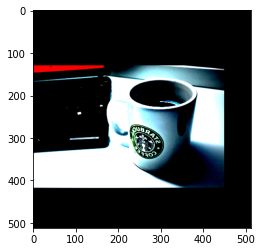

In [118]:
b = 0
img_r = img['input'][b].permute(1,2,0)
img_hm = img['hm'][b]
plt.imshow(img_r)

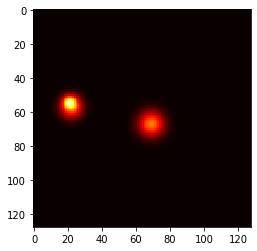

In [119]:
plt.imshow(torch.sum(img_hm,dim=0), cmap='hot', interpolation='nearest')

In [106]:
torch.max(torch.sum(img_hm,dim=0))

tensor(1.)

In [14]:
from models.fewdecode import fewdet_decode
from models.fewdecode import _nms
from models.fewdecode import _gather_feat

In [35]:
output = img['hm']
scores = _nms(output)

In [36]:
batch, cat, height, width = output.size()

In [37]:
topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), 100)
print(topk_scores.size())
print(topk_inds.size())

torch.Size([2, 80, 100])
torch.Size([2, 80, 100])


In [38]:
topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), 100)
topk_inds = topk_inds % (height * width)
print(topk_score.size())
print(topk_ind.size())
topk_clses = (topk_ind / 100).int()
print(topk_clses.size())

torch.Size([2, 100])
torch.Size([2, 100])
torch.Size([2, 100])


In [19]:
topk_inds = topk_inds % (height * width)
topk_ys   = (topk_inds / width).int().float()
topk_xs   = (topk_inds % width).int().float()

In [48]:
topk_xs

tensor([[[92., 78., 78.,  ...,  2.,  6., 14.],
         [78., 94., 46.,  ..., 14., 30., 62.],
         [78., 94., 46.,  ..., 14., 30., 62.],
         ...,
         [78., 94., 46.,  ..., 14., 30., 62.],
         [78., 94., 46.,  ..., 14., 30., 62.],
         [78., 94., 46.,  ..., 14., 30., 62.]],

        [[78., 94., 46.,  ..., 14., 30., 62.],
         [78., 94., 46.,  ..., 14., 30., 62.],
         [78., 94., 46.,  ..., 14., 30., 62.],
         ...,
         [78., 94., 46.,  ..., 14., 30., 62.],
         [78., 94., 46.,  ..., 14., 30., 62.],
         [78., 94., 46.,  ..., 14., 30., 62.]]])

In [42]:
topk_inds = _gather_feat(
        topk_inds.view(batch, -1, 1), topk_ind).view(batch, 100)

In [44]:
topk_inds

tensor([[ 8924,  9550,    83,    11,    49,    75,    20,    91,    52,     5,
            58,    13,    71,     8,    79,    90,    87,     4,    95,    26,
             6,    56,    27,    66,    29,    32,    63,    69,    36,    73,
            82,    77,    40,    81,    22,    85,    44,    89,    98,    93,
            48,    97,    94,     0,    25,    14,    54,    55,    28,    57,
            70,    59,    64,    60,    34,    31,    68,    65,    33,    72,
             7,    18,    35,    76,    17,    86,    37,    80,     3,    42,
            39,    84,    19,    46,    41,    88,     9,    10,    43,    92,
            21,    50,    45,    96,     1,    24,    47,    99,    23,    61,
            51,     2,    12,    53,    15,    78,    38,    74,    16,    67],
        [11442, 12386,    41,    51,     0,    37,    88,    45,    12,    55,
            60,    59,    35,    80,    39,    10,    43,    96,    47,    66,
            30,    28,    57,    34,    63,    68, 

In [49]:
topk_score

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [50]:
topk_clses

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15, 62,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=torch.int32)